<a href="https://colab.research.google.com/github/Apekshagaonkar/dl_covid/blob/main/Normal_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)
%cd "/content/drive/My Drive/Covid19AI"

Mounted at /content/drive
/content/drive/My Drive/Covid19AI


external image(s) shape: (320, 320, 3)
Prediction without Segmentation


Text(0.5, 1.0, 'pred=0.7484    pred_label= Pnuemonia')

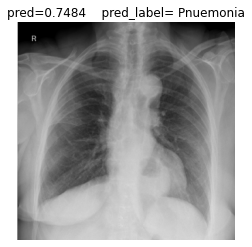

In [109]:
from keras.preprocessing.image import load_img, img_to_array
import cv2.cv2 as cv2, numpy as np
#from keras.applications import DenseNet121
#from keras.layers import Dense, GlobalAveragePooling2D
from keras import Model
from tensorflow.keras.models import load_model


IMG_PATH = ['/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/190.jpeg', '0']
IMG_SHAPE = (320, 320, 3)

test_img = load_img(path=IMG_PATH[0], color_mode='grayscale')
test_img = img_to_array(img=test_img, data_format='channels_last')
test_img = cv2.resize(test_img, dsize=IMG_SHAPE[:2], interpolation=cv2.INTER_NEAREST)
test_img = np.expand_dims(test_img, axis=-1)
test_img = test_img.astype(np.uint8)
test_img = test_img / 255.
test_img = np.concatenate((test_img, test_img, test_img), axis=-1)
print('external image(s) shape:', test_img.shape)

print('Prediction without Segmentation')
labels = ['Normal', 'Pnuemonia', 'Others']
predictor = load_model('/content/drive/My Drive/Covid19AI/covid_model/eps=018_valLoss=0.4167.hdf5')
pred = predictor.predict(np.expand_dims(test_img, axis=0))
pred_label = labels[np.argmax(pred)]

plt.imshow(test_img)
plt.axis('off')
plt.title('pred=%.4f    pred_label= %s' % (np.max(pred), pred_label))

In [110]:
import glob, numpy as np, cv2, matplotlib.pyplot as plt, tensorflow as tf, copy
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8, normalize=True):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(inputs=[self.model.input], outputs=[self.model.get_layer(self.layerName).output,
                                                              self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            inputs = np.expand_dims(inputs, axis=0)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # if gradients are too small (GradCAM is zero everywhere)
        # equal to changing the value of 'eps' func arg
        grads = grads / (grads.numpy().max() - grads.numpy().min())
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        h, w = image.shape[:2]
        heatmap = cv2.resize(cam.numpy(), (w, h))
        print('avg heatmap value:', np.mean(heatmap))
        print('max heatmap value:', np.max(heatmap))
        # ignore certain values lower than a threshold to get sharper heatmaps
        # heatmap[np.where(heatmap < 1)] = 0
        if normalize:
            # normalize the heatmap such that all values lie in the range
            # [0, 1], scale the resulting values to the range [0, 255],
            # and then convert to an unsigned 8-bit integer
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255)
        return heatmap.astype("uint8")

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        # if the input image is grey-scale, convert it to 3-dim
        if len(image.shape) == 2 or image.shape[-1] != 3:
            image = cv2.cvtColor(src=image, code=cv2.COLOR_GRAY2RGB)
        # if image px values are in [0, 1], upscale to [0, 255]
        if np.max(image) <= 1.0:
            image = image * 255.0
        output = cv2.addWeighted(image.astype('uint8'), alpha, heatmap, 1 - alpha, 0)
        return output

avg heatmap value: 17.242264
max heatmap value: 35.262268


Text(0.5, 1.0, 'pred=0.7484    pred_label= Pnuemonia')

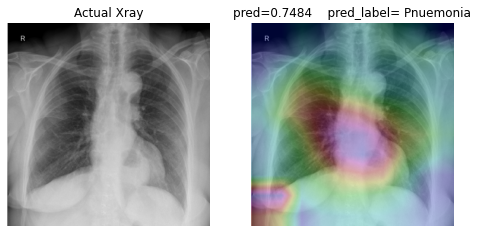

In [111]:
test_img = cv2.resize(src=test_img, dsize=(320, 320))
plain_img = test_img[:, :, 2]
temp_img = (plain_img * 255.).astype('uint8')

cam = GradCAM(model=predictor, classIdx=np.argmax(pred), layerName=None)
heatmap = cam.compute_heatmap(image=test_img, normalize=True)
overlaid_heatmap = cam.overlay_heatmap(heatmap=heatmap, image=temp_img, alpha=0.8, colormap=cv2.COLORMAP_HSV)

#overlaid_heatmap = overlaid_heatmap[75:245, 75:245, :]
#test_img = test_img[75:245, 75:245]

fig = plt.figure(num=2, figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.axis('off')
plt.title('Actual Xray')

plt.subplot(1, 2, 2)
plt.imshow(overlaid_heatmap)
plt.axis('off')
plt.title('pred=%.4f    pred_label= %s' % (np.max(pred), pred_label))